# Retrieving data from Twitter API to analyse tweet activity and post contents.

In [264]:
# Importing necessary Python libraries
import csv
from datetime import datetime
import re
import requests
import twitter
import lxml.html
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

In [265]:
# Assigning Twitter API key and token parameters
consumer_key = 'key'
consumer_secret = 'key_secret'
token = 'token'
token_secret = 'token_secret'

In [266]:
t = twitter.Api(consumer_key, consumer_secret, token, token_secret, tweet_mode='extended') 
# this ensures that we get the full text of the users' original tweets

In [267]:
# Selecting Twitter user for analysis
screen_name = "@EBU_HQ"

In [270]:
# Call the Twitter API using the python-twitter library
first_200 = t.GetUserTimeline(screen_name=screen_name, count=200)

In [271]:
# Since the number of Twitter API requests is limited to 900 per 15 minutes we will create a function that makes 900 requests
# retrieving 200 posts at each request and adding them to the list. Each post is stored as a separate item in the list
# with all the metadata in the dictionary format

def get_tweets(first_200, screen_name, last_id):
    all_tweets = []
    all_tweets.extend(first_200)
    for i in range(900):
        new = t.GetUserTimeline(screen_name=screen_name, max_id=last_id-1)
        if len(new) > 0:
            all_tweets.extend(new)
            last_id = new[-1].id
        else:
            break
    
    return all_tweets

In [272]:
all_tweets = get_tweets(first_200, screen_name, first_200[-1].id)

In [273]:
# now to check the data
print("There are %d tweets stored in a list as the all_tweets variable." % len(all_tweets))
print("The most recent tweet in our collection was sent %s and the oldest tweet was sent %s." % (
                                                                            all_tweets[0].created_at, 
                                                                            all_tweets[-1].created_at)
     )

There are 3233 tweets stored in a list as the all_tweets variable.
The most recent tweet in our collection was sent Mon Jul 01 09:08:15 +0000 2019 and the oldest tweet was sent Tue Mar 22 09:16:15 +0000 2016.


In [274]:
# Twitter API provides a lot of metadata for each post.
print(all_tweets[0])

{"created_at": "Mon Jul 01 09:08:15 +0000 2019", "favorite_count": 1, "full_text": "As the @FIFAWWC reaches its final stages we are celebrating #WomenInSport across our network of #PublicServiceMedia broadcasters, including our Member @RTV_Slovenija\ud83c\uddf8\ud83c\uddee\ud83d\udcfa\n \nTogether we will #KeepMediaGood and support women in sport https://t.co/lj9XyKoopR", "hashtags": [{"text": "WomenInSport"}, {"text": "PublicServiceMedia"}, {"text": "KeepMediaGood"}], "id": 1145620117956562944, "id_str": "1145620117956562944", "lang": "en", "media": [{"display_url": "pic.twitter.com/lj9XyKoopR", "expanded_url": "https://twitter.com/RTV_Slovenija/status/1142450258703765504/video/1", "id": 1142450171999133696, "media_url": "http://pbs.twimg.com/ext_tw_video_thumb/1142450171999133696/pu/img/82WTO_Zfk8X9fLAS.jpg", "media_url_https": "https://pbs.twimg.com/ext_tw_video_thumb/1142450171999133696/pu/img/82WTO_Zfk8X9fLAS.jpg", "sizes": {"large": {"h": 350, "resize": "fit", "w": 624}, "medium"

In [276]:
# Let's have a look on a few key attributes that we might use.
print("Data in the created_at attribute looks like this:", all_tweets[1].created_at)
print("Data in the hashtags attribute looks like this:", all_tweets[1].hashtags)
print("Data in the urls attribute looks like this:", all_tweets[1].urls)
print("Data in the source attribute looks like this:", all_tweets[1].source)

Data in the created_at attribute looks like this: Mon Jul 01 07:19:59 +0000 2019
Data in the hashtags attribute looks like this: [Hashtag(Text='WCSJ2019'), Hashtag(Text='PublicServiceMedia')]
Data in the urls attribute looks like this: [URL(URL=https://t.co/xRizud9lEy, ExpandedURL=http://bit.ly/31X2swl)]
Data in the source attribute looks like this: <a href="https://www.hootsuite.com" rel="nofollow">Hootsuite Inc.</a>


In [277]:
# Tweet attribute fields contain a lot of information we won't need. Let's create functions to clean the raw data
# for hashtag, expanded url, source and date attributes of a post.

def clean_hashtags(hashtags):
    """
    Turns data with any number of hashtags like this - [Hashtag(Text='PublicServiceMedia)] - to a list like this -
    ['PublicServiceMedia]
    """
    cleaned = []
    if len(hashtags) >= 1:
        for i in range(len(hashtags)):
            cleaned.append(hashtags[i].text)        
    return cleaned

def clean_urls(urls):
    """
    Turns data with any number of expanded urls like this - 
    [URL(URL=https://t.co/sYCFHKxzBf, ExpandedURL=https://youtu.be/34bFgA3H3hQ)]- to a list like this - 
    ["https://youtu.be/34bFgA3H3hQ"]
    """
    cleaned = []
    if len(urls) >= 1:
        for i in range(len(urls)):
            cleaned.append(urls[i].expanded_url)
    return(cleaned)
        

def clean_source(source):
    """
    Turns data including the source and some html like this - 
    <a href="https://www.sprinklr.com" rel="nofollow">Sprinklr</a> - to a list like this -
    ['Sprinklr']
    """
    raw = lxml.html.document_fromstring(source)
    return raw.cssselect('body')[0].text_content()


def string_to_datetime(date_str):
    """
    Turns a string including date and time like this - Sun Jul 01 21:06:07 +0000 2018 - to a Python datetime object
    like this - datetime.datetime(2018, 7, 1, 21, 6, 7, tzinfo=datetime.timezone.utc)
    """
    return datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y')

In [278]:
# creating a function that writes data of post attributes that we are interested in to a csv file.

def write_to_csv(tweets, filename):
    # the headers of the fields that will be saved for future analysis
    headers = ['id', 'full_text', 'hashtags', 'urls', 'created_at', 'favorite_count', 'retweet_count', 'source']
    
    # create the file and write the header row with the headers list    
    with open(filename + '.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(headers)
        
        # write a new row for each tweet object, with the data taken from the tweet object in 
        # the order we listed the headers and applying the created functions for data claening.       
        for item in tweets:
            writer.writerow([item.id, 
                             item.full_text, 
                             clean_hashtags(item.hashtags), 
                             clean_urls(item.urls), 
                             item.created_at, 
                             item.favorite_count, 
                             item.retweet_count, 
                             clean_source(item.source)])
    csvfile.close()

In [279]:
# Write the data to csv file.
write_to_csv(all_tweets, screen_name + '_tweets')

In [506]:
# import .csv data into Pandas Dataframe and filter data for the last 12 full months

file1 = 'https://www.dropbox.com/s/490uu5igtdkug5g/%40EBU_HQ_tweets.csv?dl=1'

In [508]:
df_raw = pd.read_csv(file1)
df_raw['created_at'] = pd.to_datetime(df_raw['created_at'])
df1 = df_raw.loc[(df_raw['created_at']>'2018-06-30 00:00:00') & (df_raw['created_at']<'2019-07-01 00:00:00')]

In [509]:
# add a date column with month&year for data aggregation and plotting
pd.options.mode.chained_assignment = None
df1.reset_index(drop = True, inplace = True)
df1['month'] = df1['created_at'].dt.strftime('%b-%Y')

In [510]:
df1.head()

,id,full_text,hashtags,urls,created_at,favorite_count,retweet_count,source,month
0,1144983177594888195,@rtve🇪🇸\n@Raiofficialnews🇮🇹\n@S4C🏴󠁧󠁢󠁷󠁬󠁳󠁿\n@1tv...,[],[],2019-06-29 14:57:16+00:00,0,0,Twitter Web Client,Jun-2019
1,1144983174440738816,EBU Members have ensured record coverage of th...,"['publicservicemedia', 'WomenInSport', 'KeepMe...",[],2019-06-29 14:57:16+00:00,9,2,Twitter Web Client,Jun-2019
2,1144612179007725571,"The #EBUGA has come to an end, but the interac...","['EBUGA', 'PublicServiceMedia']",['http://ow.ly/8oyi50uOkkY'],2019-06-28 14:23:03+00:00,5,4,Twitter for iPhone,Jun-2019
3,1144589526691655680,Thanks to the 150 members that attended our #E...,"['EBUGA', 'PublicServiceMedia']",[],2019-06-28 12:53:03+00:00,12,1,Hootsuite Inc.,Jun-2019
4,1144529716319309826,.@svt reached gender balance in 2003 👩👨 \n\nBu...,['EBUGA'],[],2019-06-28 08:55:23+00:00,5,3,Twitter Web Client,Jun-2019


In [511]:
# To get a high-level view on the account activity let's look at key activity and engagement indicators
# (number of tweets, favorites and retweets) during last 12 months.
# To do tihs we need to aggregate data on a monthly level in a new dataframe

aggregations = {
    'id':'count',
    'favorite_count':'sum',
    'retweet_count':'sum'    
}

In [512]:
df_sum = df1.filter(['id', 'favorite_count', 'retweet_count', 'month'], axis = 1)
df_sum = df_sum.groupby('month', as_index = False, sort = False).agg(aggregations).iloc[::-1]
df_sum = df_sum.rename(columns={"id": "tweets", "favorite_count": "favorites, total", "retweet_count": "retweets, total"})
df_sum.reset_index(drop = True)

# As we can see there are three months with significantly increased levelsof activity, let's plot this. 

,month,tweets,"favorites, total","retweets, total"
0,Jul-2018,50,673,322
1,Aug-2018,84,1273,1306
2,Sep-2018,54,385,311
3,Oct-2018,48,225,483
4,Nov-2018,166,1068,2751
5,Dec-2018,99,1022,433
6,Jan-2019,71,1443,1050
7,Feb-2019,67,595,631
8,Mar-2019,135,1444,1003
9,Apr-2019,71,720,351


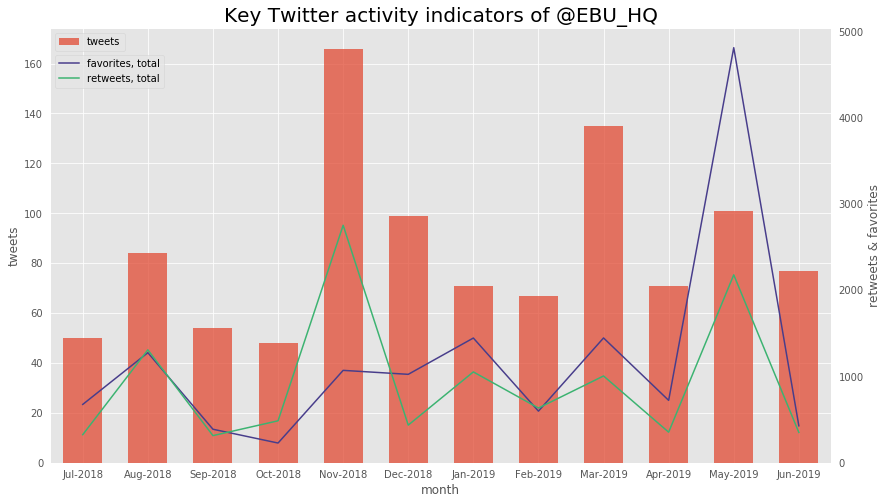

In [513]:
mpl.style.use('ggplot')
ax = plt.gca()
ax2 = ax.twinx()

df_sum.plot(kind='bar', x = 'month', y = 'tweets', width = 0.6, alpha=0.75, rot=0, ax = ax, figsize=(14,8))
df_sum.plot(kind='line', x = 'month', y = 'favorites, total', ax = ax2, figsize=(14,8), color='darkslateblue')
df_sum.plot(kind='line', x = 'month', y = 'retweets, total', ax = ax2, figsize=(14,8), color='mediumseagreen')

ax.set_ylabel('tweets')
ax.set_xlim(left=-0.5, right= df_sum['month'].nunique()-0.5)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.legend(loc='upper left')
ax2.set_ylabel('retweets & favorites')
ax2.yaxis.set_ticks_position('none')
ax2.grid(False)
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))

plt.title('Key Twitter activity indicators of %s'%screen_name, fontsize=20)

plt.show()

The engagement level is the highest in May. No surprises here -  this is the month of **Eurovision**! 

In [514]:
# Now let's get an insight into tweet contents. Wordcloud is a nice graph that gives overall information on the text content. 

#Let's select top 3 months by number of tweets.
monthTop1 = df1['month'].value_counts().sort_values(ascending = False).index.tolist()[0]
monthTop2 = df1['month'].value_counts().sort_values(ascending = False).index.tolist()[1]
monthTop3 = df1['month'].value_counts().sort_values(ascending = False).index.tolist()[2]

# and create new dataframes for each month
df_m1 = df1.loc[df1['month'] == monthTop1]
df_m2 = df1.loc[df1['month'] == monthTop2]
df_m3 = df1.loc[df1['month'] == monthTop3]

In [515]:
# in case we need it - write all the tweets of each month to separate .txt files for further analysis.
with open('%s_m1_tweets.txt'%screen_name, 'w') as f:
    for text in df_m1['full_text'].tolist():
        f.write(text + '\n')
        
with open('%s_m2_tweets.txt'%screen_name, 'w') as f:
    for text in df_m2['full_text'].tolist():
        f.write(text + '\n')

with open('%s_m3_tweets.txt'%screen_name, 'w') as f:
    for text in df_m3['full_text'].tolist():
        f.write(text + '\n')        

In [516]:
# create a list containing text of all tweets for each month.
m1Tweets = df_m1['full_text'].to_list()
m2Tweets = df_m2['full_text'].to_list()
m3Tweets = df_m3['full_text'].to_list()

In [517]:
# we need to convert this list to a string varable and for a better Wordcloud representation to clean it 
# from as much non-verbal informtion (links, non-printable characers, emojis, etc.) as possible.
# the function below does just that.

def clean_tweet(string):
    
    string = ' '.join(string)
    string = re.sub(r"http\S+", "", str(string), flags=re.MULTILINE)
    string = re.sub(r"RT", "", str(string), flags=re.MULTILINE)
    string = re.sub(r"amp", "", str(string), flags=re.MULTILINE)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string).replace("\n", "")

In [518]:
# now let's clean the text of tweets
Tweets_clean1 = clean_tweet(m1Tweets)
Tweets_clean2 = clean_tweet(m2Tweets)
Tweets_clean3 = clean_tweet(m3Tweets)

In [519]:
# create funciton to draw a Wordcloud
def draw_wordcloud(month, tweets):
    
    stopwords = set(STOPWORDS)
    tweetCloud = WordCloud(
    background_color='black',
    max_words=2000,
    stopwords=stopwords
        )
    tweetCloud.generate(tweets)
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(18)
    plt.imshow(tweetCloud, interpolation='bilinear')
    plt.title('This is the Wordcloud of %s Tweets'%month, fontsize=20)
    plt.axis('off')
    plt.show()

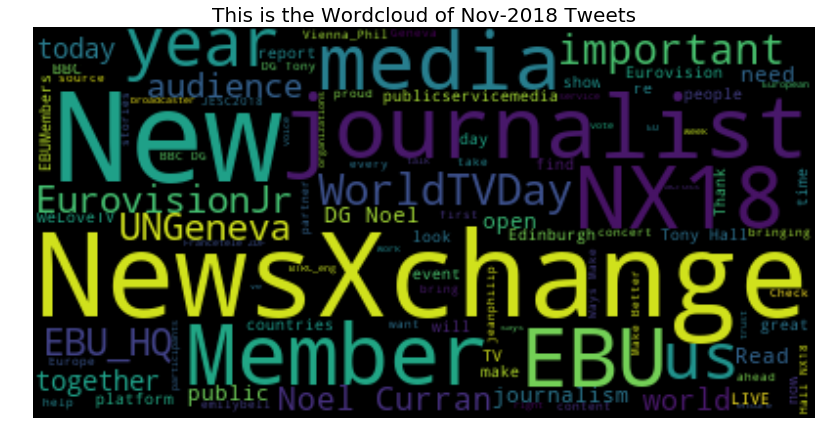

In [481]:
# and now we can draw Wordclouds for each month with one line of code
draw_wordcloud(monthTop1, Tweets_clean1)

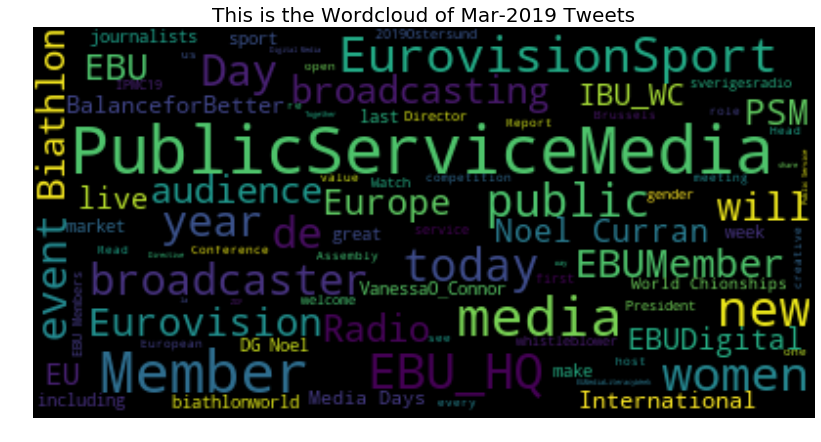

In [478]:
draw_wordcloud(monthTop2, Tweets_clean2)

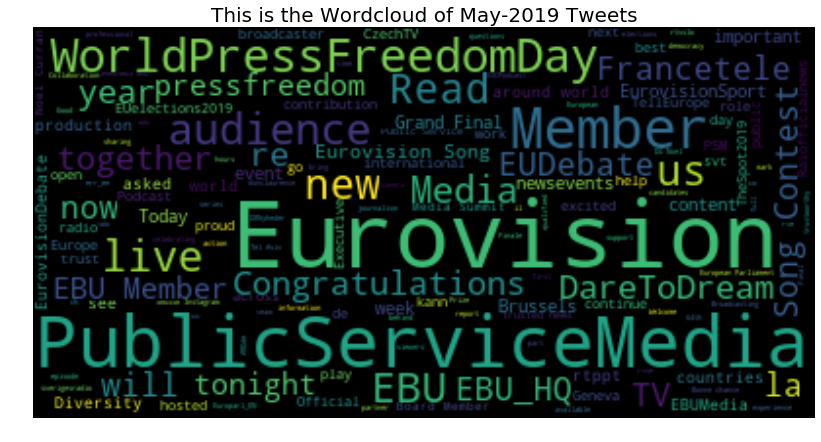

In [480]:
draw_wordcloud(monthTop3, Tweets_clean3)

I think we've got a pretty good idea what were the important EBU topics, events and activities in November, March and May!